In [ ]:
import pandas as pd
import io
from google.colab import files

# --- Configuration Constants (can be adjusted if needed) ---
# For Precipitation Data that might be in NASA POWER format
NASA_PRECIP_SKIP_HEADER_LINES = 9
NASA_PRECIP_VALUE_COL_NAME = 'PRECTOTCORR'
NASA_PRECIP_MISSING_VAL = -999.0

# --- Function to process a generic or NASA POWER precipitation file ---
def process_precipitation_data(file_content_bytes, uploaded_filename):
    """
    Processes uploaded precipitation data.
    Tries to detect NASA POWER format first, then falls back to generic CSV.
    Prompts user for column names if format is generic.
    """
    print(f"\n--- Processing Precipitation File: {uploaded_filename} ---")
    df_precip_processed = None

    # Attempt 1: Try reading as NASA POWER format
    try:
        print(f"Attempting to read '{uploaded_filename}' as NASA POWER format (skipping {NASA_PRECIP_SKIP_HEADER_LINES} header lines)...")
        # Use a new BytesIO buffer for each read attempt
        df_try_nasa = pd.read_csv(io.BytesIO(file_content_bytes), skiprows=NASA_PRECIP_SKIP_HEADER_LINES)

        if all(col in df_try_nasa.columns for col in ['YEAR', 'MO', 'DY', NASA_PRECIP_VALUE_COL_NAME]):
            print("NASA POWER format detected based on YEAR, MO, DY columns.")
            df_try_nasa['Date'] = pd.to_datetime(df_try_nasa[['YEAR', 'MO', 'DY']].rename(
                columns={'YEAR':'year', 'MO':'month', 'DY':'day'}))

            precip_val_col = NASA_PRECIP_VALUE_COL_NAME
            df_try_nasa[precip_val_col] = pd.to_numeric(df_try_nasa[precip_val_col], errors='coerce')
            df_try_nasa[precip_val_col] = df_try_nasa[precip_val_col].replace(NASA_PRECIP_MISSING_VAL, pd.NA)

            df_precip_processed = df_try_nasa[['Date', precip_val_col]].rename(columns={precip_val_col: 'PRECTOTCORR (mm)'})
            df_precip_processed.dropna(subset=['Date', 'PRECTOTCORR (mm)'], inplace=True)
            print("Precipitation data processed successfully (NASA format).")
            return df_precip_processed
        else:
            print("Did not find typical NASA POWER columns (YEAR, MO, DY). Will try as generic CSV.")
    except Exception as e_nasa:
        print(f"Could not process as NASA POWER format: {e_nasa}. Will try as generic CSV.")

    # Attempt 2: Try reading as a generic CSV
    try:
        print(f"\nAttempting to read '{uploaded_filename}' as a generic CSV...")
        # Use a new BytesIO buffer for each read attempt
        df_generic_precip = pd.read_csv(io.BytesIO(file_content_bytes)) # Read without skipping for inspection

        print("\nPreview of precipitation file columns (generic attempt):")
        print(df_generic_precip.head(3))
        print("Columns found:", list(df_generic_precip.columns))

        date_col_precip = input("Enter the EXACT name of the 'Date' column in this precipitation file: ").strip()
        precip_val_col_generic = input(f"Enter the EXACT name of the precipitation value column (e.g., 'Rainfall', '{NASA_PRECIP_VALUE_COL_NAME}'): ").strip()

        if date_col_precip not in df_generic_precip.columns:
            raise KeyError(f"Date column '{date_col_precip}' not found in the precipitation file.")
        if precip_val_col_generic not in df_generic_precip.columns:
            raise KeyError(f"Precipitation value column '{precip_val_col_generic}' not found in the precipitation file.")

        df_generic_precip['Date'] = pd.to_datetime(df_generic_precip[date_col_precip], errors='coerce')
        df_generic_precip[precip_val_col_generic] = pd.to_numeric(df_generic_precip[precip_val_col_generic], errors='coerce')

        df_precip_processed = df_generic_precip[['Date', precip_val_col_generic]].rename(columns={precip_val_col_generic: 'PRECTOTCORR (mm)'})
        df_precip_processed.dropna(subset=['Date', 'PRECTOTCORR (mm)'], inplace=True)
        print("Precipitation data processed successfully (generic format).")
        return df_precip_processed

    except Exception as e_generic:
        print(f"Error processing precipitation file as generic CSV: {e_generic}")
        return None


# --- Function to process a generic stock price file ---
def process_stock_data(file_content_bytes, uploaded_filename):
    """
    Processes uploaded stock price data.
    Tries common encodings and prompts user for column names.
    """
    print(f"\n--- Processing Stock Price File: {uploaded_filename} ---")
    df_stock_processed = None
    encodings_to_try = ['utf-8', 'latin1', 'cp1252', 'iso-8859-1']

    for encoding in encodings_to_try:
        try:
            print(f"Attempting to read stock file with encoding: {encoding}...")
            # Use a new BytesIO buffer for each read attempt
            df_try_stock = pd.read_csv(io.BytesIO(file_content_bytes), encoding=encoding)
            print(f"Successfully read stock file with encoding: {encoding}")

            print("\nPreview of stock file columns:")
            print(df_try_stock.head(3))
            print("Columns found:", list(df_try_stock.columns))

            date_col_stock = input("Enter the EXACT name of the 'Date' column in this stock file: ").strip()
            stock_price_col = input("Enter the EXACT name of the stock price column (e.g., 'LTP', 'Close', 'Close Price'): ").strip()

            if date_col_stock not in df_try_stock.columns:
                raise KeyError(f"Date column '{date_col_stock}' not found in the stock file.")
            if stock_price_col not in df_try_stock.columns:
                raise KeyError(f"Stock price column '{stock_price_col}' not found in the stock file.")

            df_try_stock['Date'] = pd.to_datetime(df_try_stock[date_col_stock], errors='coerce')

            # Clean stock price column (handle potential commas)
            if df_try_stock[stock_price_col].dtype == 'object': # If read as string
                df_try_stock[stock_price_col] = df_try_stock[stock_price_col].astype(str).str.replace(',', '', regex=False)
            df_try_stock[stock_price_col] = pd.to_numeric(df_try_stock[stock_price_col], errors='coerce')

            # Select and rename columns (standardize stock price column to 'LTP' for merging)
            df_stock_processed = df_try_stock[['Date', stock_price_col]].rename(columns={stock_price_col: 'LTP'})
            df_stock_processed.dropna(subset=['Date', 'LTP'], inplace=True) # Ensure no NaNs in critical columns
            print("Stock data processed successfully.")
            return df_stock_processed # Success, exit loop and function

        except UnicodeDecodeError:
            print(f"Failed to decode stock file with {encoding}. Trying next encoding...")
        except KeyError as e_key:
            print(f"Column name error with encoding {encoding}: {e_key}. You might need to re-check column names for this encoding or try another encoding.")
            # Don't break here, another encoding might parse columns differently if the file is unusual
        except Exception as e_other:
            print(f"An unexpected error occurred while processing stock file with encoding {encoding}: {e_other}")
            # Potentially break or log, depending on how fatal this error is considered

    if df_stock_processed is None:
        print("Could not process stock file with any of the tried encodings or encountered critical errors.")
    return df_stock_processed


# --- Main Script ---
df_precip = None
df_stock = None

# 1. Upload and Process Precipitation Data
print("--- Step 1: Upload Precipitation Data File ---")
uploaded_precip_files = files.upload()
if uploaded_precip_files:
    precip_filename_key = list(uploaded_precip_files.keys())[0] # Get the first uploaded file's key
    df_precip = process_precipitation_data(uploaded_precip_files[precip_filename_key], precip_filename_key)
    if df_precip is not None and not df_precip.empty:
        print("\nProcessed Precipitation Data Head:")
        print(df_precip.head())
else:
    print("No precipitation file uploaded.")

# 2. Upload and Process Stock Data (only if precipitation data was successful)
if df_precip is not None and not df_precip.empty:
    print("\n--- Step 2: Upload Hydropower Stock Price Data File ---")
    uploaded_stock_files = files.upload()
    if uploaded_stock_files:
        stock_filename_key = list(uploaded_stock_files.keys())[0]
        df_stock = process_stock_data(uploaded_stock_files[stock_filename_key], stock_filename_key)
        if df_stock is not None and not df_stock.empty:
            print("\nProcessed Stock Data Head:")
            print(df_stock.head())
    else:
        print("No stock price file uploaded.")
else:
    print("\nSkipping stock data upload as precipitation data was not processed successfully.")


# 3. Merge DataFrames (only if both were successful)
if df_precip is not None and not df_precip.empty and \
   df_stock is not None and not df_stock.empty:

    print("\n--- Step 3: Merging Precipitation and Stock Data ---")

    # Perform an INNER merge on the 'Date' column.
    # This ensures that only dates present in BOTH DataFrames are kept.
    # Since df_stock effectively represents trading days (days with stock prices),
    # the merged DataFrame will only contain data for those days.
    df_merged = pd.merge(df_precip, df_stock, on='Date', how='inner')

    # Sort by date (good practice)
    df_merged = df_merged.sort_values('Date').reset_index(drop=True)

    if df_merged.empty:
        print("No overlapping dates found where both precipitation and stock data are available.")
        print("Please check the date ranges and formats in your uploaded files.")
        if not df_precip.empty: print(f"Precipitation data date range: {df_precip['Date'].min()} to {df_precip['Date'].max()}")
        if not df_stock.empty: print(f"Stock data date range: {df_stock['Date'].min()} to {df_stock['Date'].max()}")
    else:
        print("\n--- Merged Data (Date, PRECTOTCORR (mm), LTP) ---")
        print(df_merged.head())
        print(f"\nTotal records in merged data: {len(df_merged)}")
        print(f"Date range of merged data: {df_merged['Date'].min().strftime('%Y-%m-%d')} to {df_merged['Date'].max().strftime('%Y-%m-%d')}")

        # Final check for NaNs in merged data (should be none due to earlier processing and inner merge)
        print("\nMissing values in merged data (should be all zeros):")
        print(df_merged.isnull().sum())

        # --- Optional: Download the merged data ---
        output_filename = 'merged_hydropower_precipitation_data.csv'
        df_merged.to_csv(output_filename, index=False)
        files.download(output_filename)
        print(f"\nFile '{output_filename}' prepared for download.")
        print("This file contains precipitation and stock price data only for days where stock price (LTP) was available.")
else:
    print("\nCannot merge data: One or both datasets were not processed successfully or are empty.")

--- Step 1: Upload Precipitation Data File ---


Saving POWER_Point_Daily_20230822_20250526_051d42N_000d77W_LST.csv to POWER_Point_Daily_20230822_20250526_051d42N_000d77W_LST (3).csv

--- Processing Precipitation File: POWER_Point_Daily_20230822_20250526_051d42N_000d77W_LST (3).csv ---
Attempting to read 'POWER_Point_Daily_20230822_20250526_051d42N_000d77W_LST (3).csv' as NASA POWER format (skipping 9 header lines)...
NASA POWER format detected based on YEAR, MO, DY columns.
Precipitation data processed successfully (NASA format).

Processed Precipitation Data Head:
        Date PRECTOTCORR (mm)
0 2023-08-22             0.04
1 2023-08-23             0.04
2 2023-08-24             3.29
3 2023-08-25             1.35
4 2023-08-26              2.2

--- Step 2: Upload Hydropower Stock Price Data File ---


Saving hydroindex.csv to hydroindex.csv

--- Processing Stock Price File: hydroindex.csv ---
Attempting to read stock file with encoding: utf-8...
Successfully read stock file with encoding: utf-8

Preview of stock file columns:
   SN       Date     Close
0   1  5/27/2025  3,440.32
1   2  5/26/2025  3,435.20
2   3  5/25/2025  3,437.36
Columns found: ['SN', 'Date', 'Close']
Enter the EXACT name of the 'Date' column in this stock file: Date
Enter the EXACT name of the stock price column (e.g., 'LTP', 'Close', 'Close Price'): Close
Stock data processed successfully.

Processed Stock Data Head:
        Date      LTP
0 2025-05-27  3440.32
1 2025-05-26  3435.20
2 2025-05-25  3437.36
3 2025-05-22  3450.06
4 2025-05-21  3488.61

--- Step 3: Merging Precipitation and Stock Data ---

--- Merged Data (Date, PRECTOTCORR (mm), LTP) ---
        Date PRECTOTCORR (mm)      LTP
0 2024-05-26              7.1  2469.88
1 2024-05-27             1.06  2476.15
2 2024-05-29             1.02  2473.32
3 2024-05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File 'merged_hydropower_precipitation_data.csv' prepared for download.
This file contains precipitation and stock price data only for days where stock price (LTP) was available.


--- Please upload your data file (e.g., 'final_precip_stock_trading_days_data.csv') ---


Saving merged_index_precipitation_data (1).csv to merged_index_precipitation_data (1) (1).csv

Uploaded file: 'merged_index_precipitation_data (1) (1).csv'
File loaded successfully into DataFrame.

--- Data Preprocessing ---
Data points available after initial processing: 229
Data Head:
            PRECTOTCORR (mm)      LTP
Date                                 
2024-05-26              7.10  2469.88
2024-05-27              1.06  2476.15
2024-05-29              1.02  2473.32
2024-05-30              2.48  2485.48
2024-06-02              0.03  2517.01

--- Exploratory Data Analysis ---


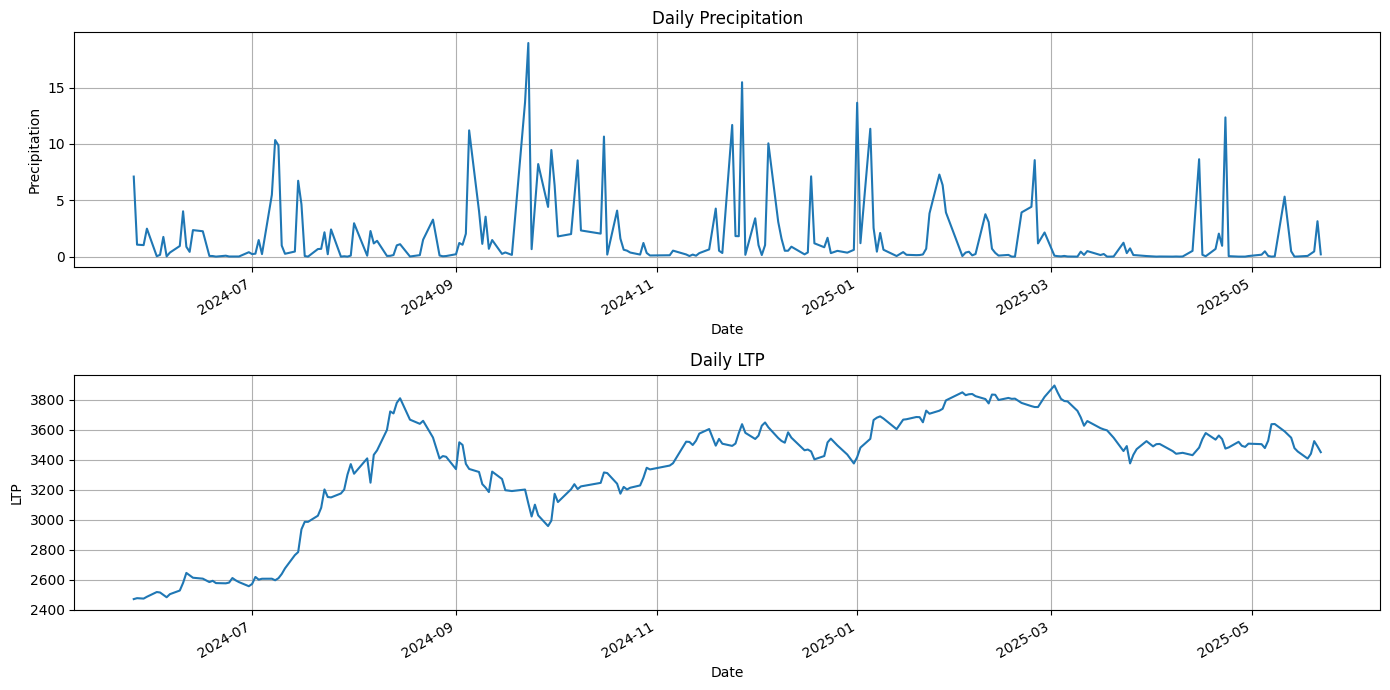


--- Correlation Analysis ---


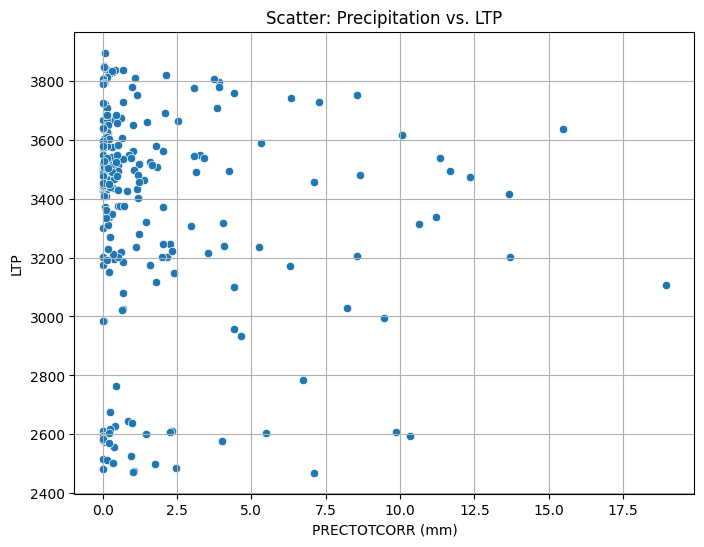


Pearson Correlation between Precipitation and LTP: -0.0787


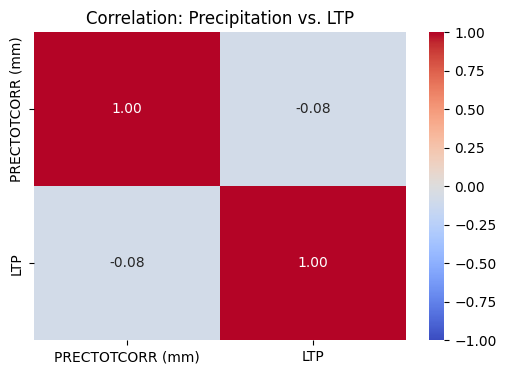


--- Preprocessing for LSTM (Scaling by Overall Max) ---
Overall Max Precipitation for scaling: 18.95
Overall Max LTP for scaling: 3894.76

Head of scaled data (first 5 rows):
[[0.37467018 0.63415461]
 [0.05593668 0.63576446]
 [0.05382586 0.63503785]
 [0.13087071 0.63815999]
 [0.00158311 0.64625548]]
Total sequences: 224


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6474 - mae: 0.7965 - val_loss: 0.5278 - val_mae: 0.7257
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3499 - mae: 0.5799 - val_loss: 0.1941 - val_mae: 0.4399
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1002 - mae: 0.2832 - val_loss: 0.0026 - val_mae: 0.0476
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - mae: 0.1304 - val_loss: 0.0070 - val_mae: 0.0819
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mae: 0.1155 - val_loss: 0.0105 - val_mae: 0.1009
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.0909 - val_loss: 0.0028 - val_mae: 0.0500
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - mae: 0.1107 - val_loss: 0.0036 - val_mae: 0.0572
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mae: 0.0982 - val_loss: 0.0064 - val_mae: 0.0779
Epoch 8: early stopping
Restoring model we

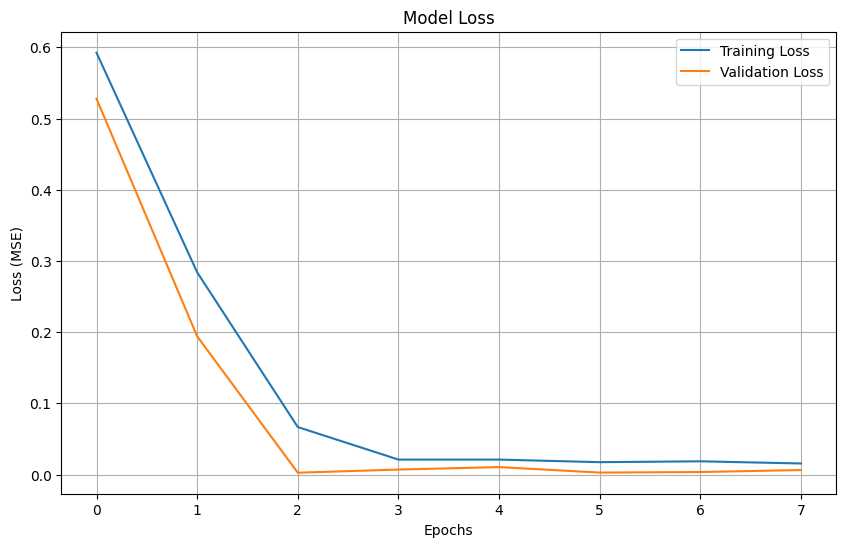


--- Model Evaluation ---


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Test RMSE: 157.8517
Test MAE: 134.9373


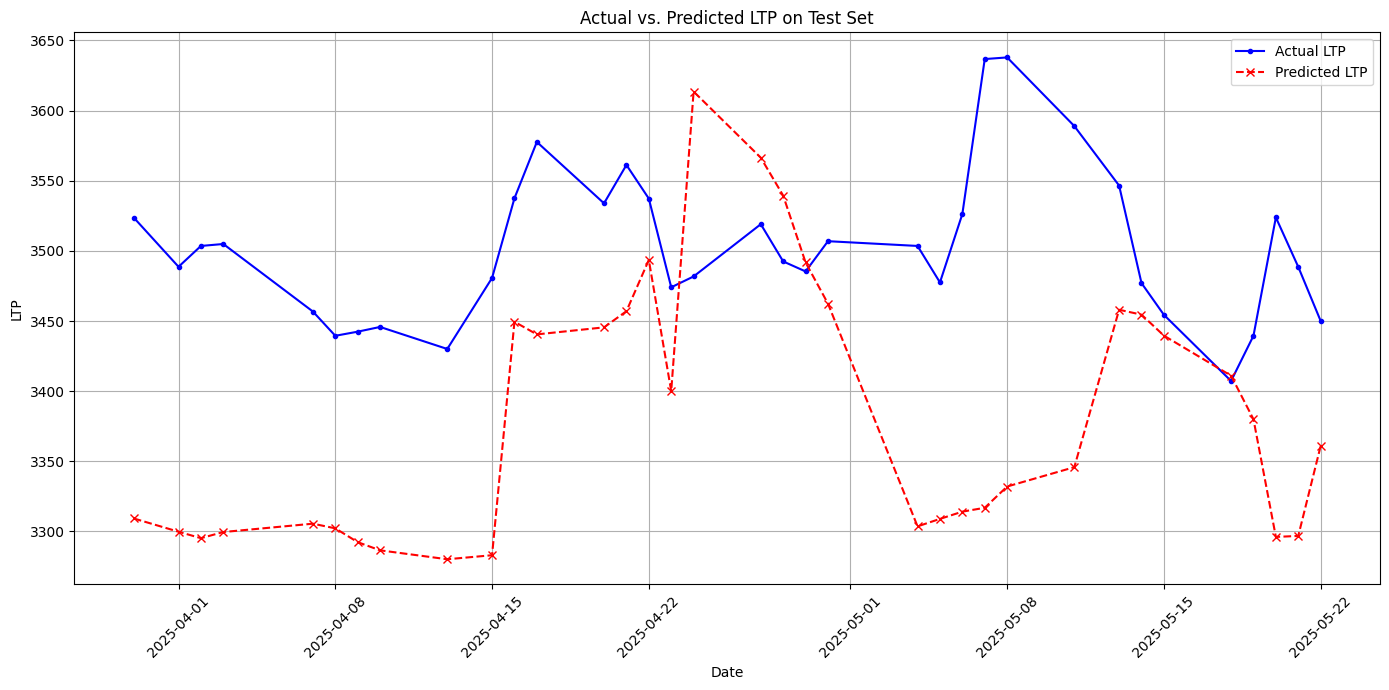


--- CALCULATIONS FOR PROPOSAL (based on full processed data) ---

Descriptive Statistics (PRECTOTCORR (mm)):
count    229.000000
mean       1.842009
std        3.185831
min        0.000000
25%        0.090000
50%        0.450000
75%        2.030000
max       18.950000
Name: PRECTOTCORR (mm), dtype: float64

Descriptive Statistics (LTP):
count     229.000000
mean     3348.695721
std       383.232233
min      2469.880000
25%      3201.270000
50%      3474.040000
75%      3603.650000
max      3894.760000
Name: LTP, dtype: float64

Pearson Correlation between PRECTOTCORR (mm) and LTP: -0.0787


In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

# --- 0. Upload and Load Data ---
print("--- Please upload your data file (e.g., 'final_precip_stock_trading_days_data.csv') ---")
uploaded = files.upload()

df = pd.DataFrame() # Initialize df
if not uploaded:
    print("No file was uploaded. Exiting script.")
    # exit()
else:
    file_name = list(uploaded.keys())[0]
    print(f"\nUploaded file: '{file_name}'")
    try:
        df = pd.read_csv(io.BytesIO(uploaded[file_name]))
        print("File loaded successfully into DataFrame.")
    except Exception as e:
        print(f"Error loading or parsing the uploaded CSV file: {e}")

if not df.empty:
    # --- b) Data Preprocessing ---
    print("\n--- Data Preprocessing ---")
    if 'Date' not in df.columns:
        print("ERROR: 'Date' column not found.")
        df = pd.DataFrame() # Invalidate df
    else:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.dropna(subset=['Date'], inplace=True) # Remove rows where date parsing failed
        df = df.sort_values('Date').set_index('Date')

    # Identify columns for precipitation and LTP/Index
    # These will be the names used throughout the rest of the script
    precip_col_name = 'PRECTOTCORR (mm)'
    price_index_col_name = 'LTP' # Or 'Hydro_Index_Value' if that's what you have

    if precip_col_name not in df.columns or price_index_col_name not in df.columns:
        print(f"ERROR: Expected columns '{precip_col_name}' and/or '{price_index_col_name}' not found.")
        print(f"Available columns: {list(df.columns)}")
        df = pd.DataFrame() # Invalidate df
    else:
        df[precip_col_name] = pd.to_numeric(df[precip_col_name], errors='coerce')
        df[price_index_col_name] = pd.to_numeric(df[price_index_col_name], errors='coerce')
        df.dropna(subset=[precip_col_name, price_index_col_name], inplace=True)

        print(f"Data points available after initial processing: {len(df)}")
        if len(df) > 0:
            print("Data Head:")
            print(df.head())
        else:
            print("No data available after initial processing and NaN drop.")

if not df.empty:
    # --- c) Exploratory Data Analysis (EDA) ---
    print("\n--- Exploratory Data Analysis ---")
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1); df[precip_col_name].plot(title='Daily Precipitation'); plt.ylabel('Precipitation'); plt.grid(True)
    plt.subplot(2, 1, 2); df[price_index_col_name].plot(title=f'Daily {price_index_col_name}'); plt.ylabel(price_index_col_name); plt.grid(True)
    plt.tight_layout(); plt.show()

    print("\n--- Correlation Analysis ---")
    plt.figure(figsize=(8, 6)); sns.scatterplot(x=precip_col_name, y=price_index_col_name, data=df); plt.title(f'Scatter: Precipitation vs. {price_index_col_name}'); plt.grid(True); plt.show()
    correlation_value = df[precip_col_name].corr(df[price_index_col_name], method='pearson')
    print(f"\nPearson Correlation between Precipitation and {price_index_col_name}: {correlation_value:.4f}")
    # ... (rest of correlation interpretation and heatmap) ...
    correlation_matrix = df[[precip_col_name, price_index_col_name]].corr(method='pearson')
    plt.figure(figsize=(6, 4)); sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1); plt.title(f'Correlation: Precipitation vs. {price_index_col_name}'); plt.show()

    # --- Preprocessing for LSTM ---
    print("\n--- Preprocessing for LSTM (Scaling by Overall Max) ---")
    features_for_lstm = df[[precip_col_name, price_index_col_name]].copy()

    if len(features_for_lstm) < 20:
        print(f"Warning: Very few data points ({len(features_for_lstm)}) for LSTM. Skipping LSTM modeling.")
    else:
        # Calculate overall maximums for scaling
        max_precip = features_for_lstm[precip_col_name].max()
        max_price_index = features_for_lstm[price_index_col_name].max()

        print(f"Overall Max Precipitation for scaling: {max_precip}")
        print(f"Overall Max {price_index_col_name} for scaling: {max_price_index}")

        # Handle cases where max might be 0 to avoid division by zero, though unlikely for price/precip
        if max_precip == 0: max_precip = 1 # Avoid division by zero, scaled precip will be 0
        if max_price_index == 0: max_price_index = 1 # Avoid division by zero

        # Perform scaling by dividing by the overall max
        scaled_precip_col = features_for_lstm[precip_col_name] / max_precip
        scaled_price_index_col = features_for_lstm[price_index_col_name] / max_price_index

        # Combine scaled features into a NumPy array for LSTM
        scaled_data = np.array(pd.concat([scaled_precip_col, scaled_price_index_col], axis=1))

        print("\nHead of scaled data (first 5 rows):")
        print(scaled_data[:5])

        def create_sequences(data, time_steps=7):
            Xs, ys = [], []
            for i in range(len(data) - time_steps):
                Xs.append(data[i:(i + time_steps)])
                ys.append(data[i + time_steps, 1]) # Target is the scaled price/index (second column)
            return np.array(Xs), np.array(ys)

        TIME_STEPS = 5
        X, y = create_sequences(scaled_data, TIME_STEPS)

        if X.shape[0] == 0:
            print(f"Error: Not enough data to create sequences with TIME_STEPS={TIME_STEPS}. Skipping LSTM.")
        else:
            train_size = int(X.shape[0] * 0.7)
            val_size = int(X.shape[0] * 0.15)
            if X.shape[0] - train_size - val_size <= TIME_STEPS : val_size = max(1, int(X.shape[0] * 0.10))

            X_train, y_train = X[:train_size], y[:train_size]
            X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
            X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]

            print(f"Total sequences: {X.shape[0]}")
            # ... (rest of the LSTM training and summary prints) ...
            if X_train.shape[0] < 1 or X_val.shape[0] < 1 or X_test.shape[0] < 1 :
                print("Error: One or more data splits are empty for LSTM. Cannot proceed.")
            else:
                model = Sequential([
                    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
                    Dropout(0.2),
                    Dense(16, activation='relu'),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
                model.summary()
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
                print("\n--- Training LSTM Model ---")
                history = model.fit(
                    X_train, y_train,
                    epochs=30, batch_size=8,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping], verbose=1
                )

                plt.figure(figsize=(10, 6)); plt.plot(history.history['loss'], label='Training Loss')
                if 'val_loss' in history.history: plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title('Model Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True); plt.show()

                print("\n--- Model Evaluation ---")
                y_pred_scaled = model.predict(X_test)

                # Inverse transform predictions and actual values
                # Predictions (y_pred_scaled) are for the scaled price/index
                y_pred_inversed = y_pred_scaled.flatten() * max_price_index # Multiply by the max_price_index

                # y_test contains the scaled actual price/index values
                y_test_inversed = y_test.flatten() * max_price_index # Multiply by the max_price_index

                rmse = np.sqrt(mean_squared_error(y_test_inversed, y_pred_inversed))
                mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
                print(f"Test RMSE: {rmse:.4f}")
                print(f"Test MAE: {mae:.4f}")

                plt.figure(figsize=(14, 7))
                test_dates_indices = df.index[-(len(y_test_inversed)):]
                plt.plot(test_dates_indices, y_test_inversed, label=f'Actual {price_index_col_name}', color='blue', marker='.')
                plt.plot(test_dates_indices, y_pred_inversed, label=f'Predicted {price_index_col_name}', color='red', linestyle='--', marker='x')
                plt.title(f'Actual vs. Predicted {price_index_col_name} on Test Set'); plt.xlabel('Date'); plt.ylabel(price_index_col_name); plt.xticks(rotation=45); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # --- g) Calculations for Proposal ---
    print("\n--- CALCULATIONS FOR PROPOSAL (based on full processed data) ---")
    if not df.empty:
        print(f"\nDescriptive Statistics ({precip_col_name}):")
        print(df[precip_col_name].describe())
        print(f"\nDescriptive Statistics ({price_index_col_name}):")
        print(df[price_index_col_name].describe())
        print(f"\nPearson Correlation between {precip_col_name} and {price_index_col_name}: {correlation_value:.4f}")
        # ... (you can add lagged correlation printouts here if df_eda_lagged was processed and not empty)
    else:
        print("Data is empty, cannot provide proposal calculations.")
else:
    print("\nScript execution halted: Initial DataFrame is empty (file upload or loading might have failed).")

--- Please upload your CSV data file ---


Saving merged_index_precipitation_data (1).csv to merged_index_precipitation_data (1).csv

Loading file: 'merged_index_precipitation_data (1).csv'

Data successfully cleaned. Here are the first 5 rows:
            PRECTOTCORR (mm)      LTP
Date                                 
2024-05-26              7.10  2469.88
2024-05-27              1.06  2476.15
2024-05-29              1.02  2473.32
2024-05-30              2.48  2485.48
2024-06-02              0.03  2517.01

--- Plotting the data over time ---


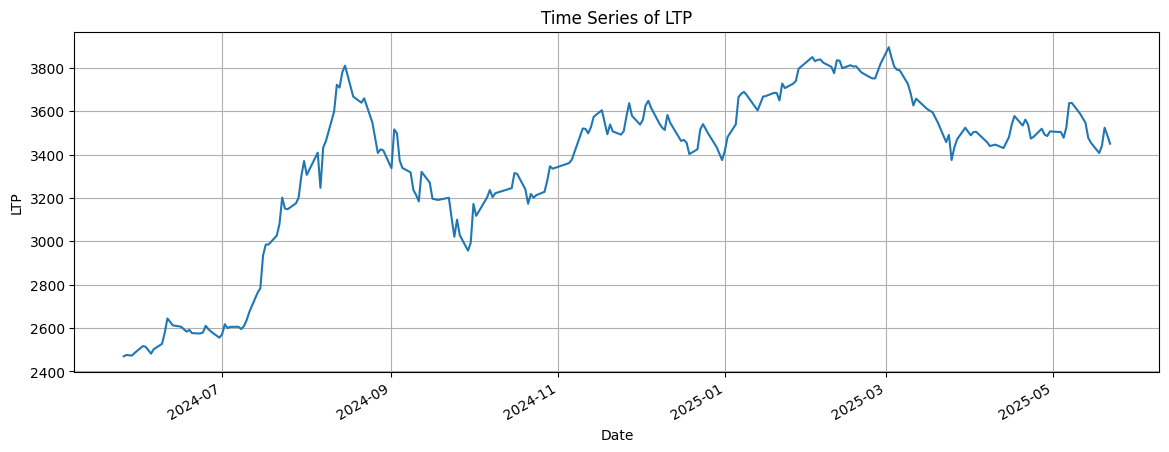

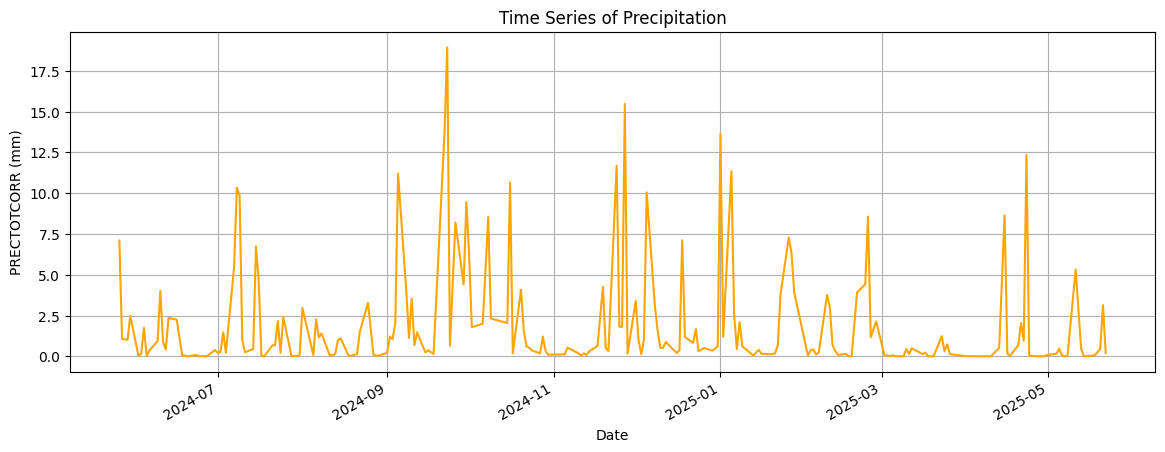


--- Checking correlation between Precipitation and Price ---
                  PRECTOTCORR (mm)       LTP
PRECTOTCORR (mm)          1.000000 -0.078666
LTP                      -0.078666  1.000000


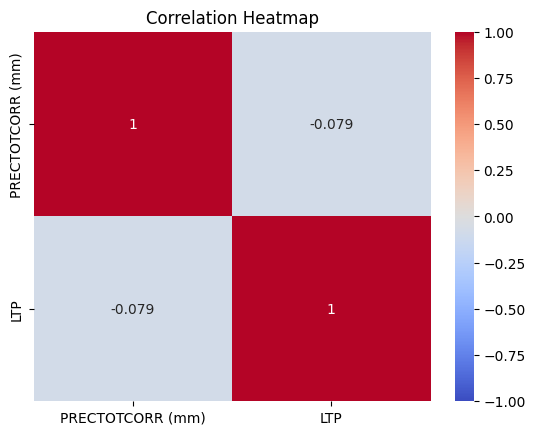


--- Preparing data for the LSTM model ---
Data shapes: X_train=(177, 7, 2), y_train=(177,), X_test=(45, 7, 2), y_test=(45,)

--- Building and Training the LSTM Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,651 (41.61 KB)

 Trainable params: 10,651 (41.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.5168 - val_loss: 0.5725
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3858 - val_loss: 0.3827
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2369 - val_loss: 0.1740
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0893 - val_loss: 0.0126
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - val_loss: 0.0082
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0327 - val_loss: 0.0063
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - val_loss: 0.0087
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0192 - val_loss: 0.0022
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - val_loss: 0.0017
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - val_loss: 0.0021
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - val_loss: 0.0026
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - val_loss: 0.0020
E

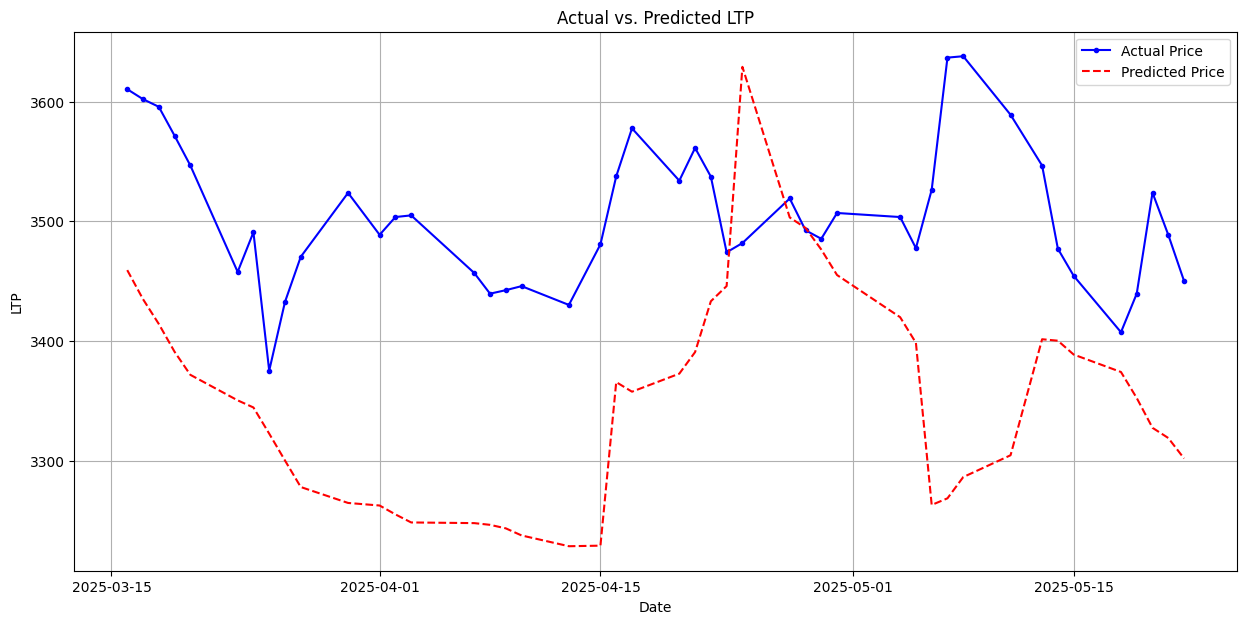

In [ ]:
# --- 1. SETUP: Import Libraries & Define Key Variables ---
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import files
PRECIP_COLUMN = 'PRECTOTCORR (mm)'
PRICE_COLUMN = 'LTP'
TIME_STEPS = 7
print("--- Please upload your CSV data file ---")
uploaded = files.upload()

# Check if a file was uploaded
if not uploaded:
    print("No file uploaded. Halting script.")
else:
    # Load the data into a pandas DataFrame
    file_name = list(uploaded.keys())[0]
    print(f"\nLoading file: '{file_name}'")
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))

    # --- Data Cleaning ---
    # a) Convert 'Date' column to datetime objects and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')

    # b) Select only the columns we need
    df_features = df[[PRECIP_COLUMN, PRICE_COLUMN]].copy()

    # c) Remove any rows with missing values in our key columns
    df_features.dropna(inplace=True)

    print("\nData successfully cleaned. Here are the first 5 rows:")
    print(df_features.head())

    # --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
    # Let's visualize the data to understand it better.
    print("\n--- Plotting the data over time ---")
    plt.figure(figsize=(14, 5))
    df_features[PRICE_COLUMN].plot(title=f'Time Series of {PRICE_COLUMN}')
    plt.ylabel(PRICE_COLUMN)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 5))
    df_features[PRECIP_COLUMN].plot(title='Time Series of Precipitation', color='orange')
    plt.ylabel(PRECIP_COLUMN)
    plt.grid(True)
    plt.show()

    # Check the relationship between precipitation and price
    print("\n--- Checking correlation between Precipitation and Price ---")
    correlation = df_features.corr(method='pearson')
    print(correlation)
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()


    # --- 4. PREPARE DATA FOR THE LSTM MODEL ---
    print("\n--- Preparing data for the LSTM model ---")

    # a) Scale the data to be between 0 and 1. Neural networks work best with small values.
    # We will scale by dividing each column by its maximum value.
    max_precip = df_features[PRECIP_COLUMN].max()
    max_price = df_features[PRICE_COLUMN].max()

    # Avoid division by zero if a column is all zeros
    if max_precip == 0: max_precip = 1
    if max_price == 0: max_price = 1

    scaled_data = df_features.copy()
    scaled_data[PRECIP_COLUMN] = scaled_data[PRECIP_COLUMN] / max_precip
    scaled_data[PRICE_COLUMN] = scaled_data[PRICE_COLUMN] / max_price

    # b) Create sequences of data.
    # The model will look at `TIME_STEPS` days of data (X) to predict the next day's price (y).
    def create_sequences(data, time_steps):
        Xs, ys = [], []
        for i in range(len(data) - time_steps):
            # The input sequence (X) is 'time_steps' number of days of both features
            Xs.append(data.iloc[i:(i + time_steps)].values)
            # The output (y) is the price of the day right after the sequence
            ys.append(data.iloc[i + time_steps][PRICE_COLUMN])
        return np.array(Xs), np.array(ys)

    X, y = create_sequences(scaled_data, TIME_STEPS)

    # c) Split data into a training set and a testing set.
    # Training set: The model learns from this data.
    # Testing set: We use this to see how well the model performs on new, unseen data.
    train_size = int(len(X) * 0.8) # 80% for training
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f"Data shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")


    # --- 5. BUILD AND TRAIN THE LSTM MODEL ---
    print("\n--- Building and Training the LSTM Model ---")
    model = Sequential([
        # LSTM layer: The "memory" part of the network. It learns from sequences.
        LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        # Dropout layer: Prevents the model from "memorizing" the data.
        Dropout(0.2),
        # Dense layer: A standard neural network layer for making the final prediction.
        Dense(units=1)
    ])

    # Compile the model: Tell it how to learn.
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    # Early stopping: Stop training if the model isn't improving, to save time.
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model!
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2, # Use 20% of training data for validation
        callbacks=[early_stopping],
        verbose=1
    )


    # --- 6. EVALUATE THE MODEL AND VISUALIZE RESULTS ---
    print("\n--- Evaluating the model performance ---")

    # a) Get the model's predictions on the test data.
    y_pred_scaled = model.predict(X_test)

    # b) VERY IMPORTANT: Un-scale the predictions and the actual values.
    # We need to convert the values from the 0-1 scale back to their original units (e.g., dollars).
    # We do this by multiplying by the maximum price we saved earlier.
    y_pred = y_pred_scaled.flatten() * max_price
    y_test_unscaled = y_test.flatten() * max_price

    # c) Calculate error metrics to see how well we did.
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
    mae = mean_absolute_error(y_test_unscaled, y_pred)
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Test Mean Absolute Error (MAE): {mae:.2f}")

    # d) Plot the results to visually compare predictions with actual values.
    plt.figure(figsize=(15, 7))
    # Get the correct dates for the x-axis of the plot
    test_dates = df_features.index[train_size + TIME_STEPS:]

    plt.plot(test_dates, y_test_unscaled, label='Actual Price', color='blue', marker='.')
    plt.plot(test_dates, y_pred, label='Predicted Price', color='red', linestyle='--')

    plt.title(f'Actual vs. Predicted {PRICE_COLUMN}')
    plt.xlabel('Date')
    plt.ylabel(PRICE_COLUMN)
    plt.legend()
    plt.grid(True)
    plt.show()